# Mount Google drive

**Note**: before proceeing, open [this Google Drive folder](https://drive.google.com/drive/folders/11VDHTT7Era4TV0gqjL-FtdnPUqovpZPe) and then click "Add shortcut to Drive" in the context menu for that folder and then choose MyDrive.

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(os.listdir('/content/drive/MyDrive/elce457_data/small'))

['hinton', 'hinton.npz', 'bengio.npz', 'bengio', 'lecun.npz', 'lecun']


Content:

- **/content/drive/MyDrive/elce457_data/small/hinton** - Hinton league
- **/content/drive/MyDrive/elce457_data/small/bengio** - Bengio league
- **/content/drive/MyDrive/elce457_data/small/lecun**  - LeCun league

**/content/drive/MyDrive/elce457_data/\*.zip** archives contain all original files in the correspoding folders.

# Hinton league

### Getting the Data

As many CV problems suffer from enormously large data, efficient input pipelines is critically important. Tensorflow has [tf.data API](https://www.tensorflow.org/guide/data), which allows you to create input pipelines.

In [ ]:
import tensorflow as tf
import os
import numpy as np
from tqdm import tqdm
import random


def hinton_allfiles():
    # list all files
    fldr = '/content/drive/MyDrive/elce457_data/small/hinton'
    files = [f'{fldr}/{t}' for t in os.listdir(fldr) if 'npz' in t]
    random.shuffle(files)
    return files


def hinton_load_data():
    files = hinton_allfiles()
    x = []
    y = []
    for _filename in tqdm(files, desc='Reading data'):
        with np.load(_filename) as d:
            x.append(d['x'].astype(np.uint8))
            y.append(d['y'].astype(np.float32))
    return np.stack(x), np.stack(y)


data_x, data_y = hinton_load_data()

Reading data: 100%|██████████| 4000/4000 [02:06<00:00, 31.58it/s] 


In [ ]:
data_y.shape

(4000, 192, 384)

###Splitting the Data

In [ ]:
from sklearn.model_selection import train_test_split


train_X, test_X, train_y, test_y = train_test_split(data_x, data_y,
                                                    train_size=0.8,
                                                    test_size=0.2,
                                                    random_state=122)


In [ ]:
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(3200, 192, 384, 3)
(800, 192, 384, 3)
(3200, 192, 384)
(800, 192, 384)


In [ ]:
batch_size = 8
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y))
dataset = dataset.shuffle(batch_size*4).batch(batch_size)
dataset = dataset.prefetch(buffer_size=4)

# iterate over dataset
for x, y in dataset:
  break

print(x.shape, y.shape)

(8, 192, 384, 3) (8, 192, 384)


In [ ]:
batch_size = 8
validation = tf.data.Dataset.from_tensor_slices((test_X, test_y))
validation = validation.shuffle(batch_size*4).batch(batch_size)
validation = validation.prefetch(buffer_size=4)

# iterate over dataset
for x, y in validation:
  break

print(x.shape, y.shape)

(8, 192, 384, 3) (8, 192, 384)


###Data Exploration

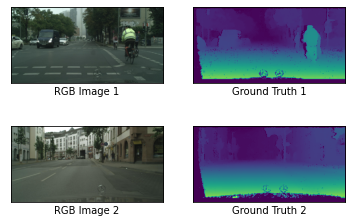

In [ ]:
import matplotlib.pyplot as plt

for x, y in dataset:
  break


plt.subplot(2,2,1)
plt.xticks([])
plt.yticks([])
plt.xlabel('RGB Image 1')
plt.grid(False)
plt.imshow(x[1],  cmap=plt.cm.binary)
plt.subplot(2,2,2)
plt.xticks([])
plt.yticks([])
plt.xlabel('Ground Truth 1')
plt.grid(False)
plt.imshow(y[1])

plt.subplot(2,2,3)
plt.xticks([])
plt.yticks([])
plt.xlabel('RGB Image 2')
plt.grid(False)
plt.imshow(x[2],  cmap=plt.cm.binary)
plt.subplot(2,2,4)
plt.xticks([])
plt.yticks([])
plt.xlabel('Ground Truth 2')
plt.grid(False)
plt.imshow(y[2])

##First Model

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
s1 = base_model.get_layer('block_7_expand_relu').output
s2 = base_model.get_layer('block_4_expand_relu').output
s3 = base_model.get_layer('block_2_expand_relu').output

In [ ]:
input = tf.keras.Input([192, 384, 3], dtype=tf.uint8, batch_size=None)
y = tf.cast(input, tf.float32)

scale_layer = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
y = scale_layer(y)

y = tf.keras.layers.Resizing(224, 224, interpolation = 'bilinear')(y)


y = base_model(y, training=False)

y = tf.keras.layers.Conv2DTranspose(960, (2, 2), strides=2, padding="same")(y)
y = tf.keras.layers.Conv2DTranspose(576, (2, 2), strides=2, padding="same")(y)
#y = tf.keras.layers.Concatenate()([y, s4])
y = tf.keras.layers.Conv2D(576, 3, padding="same")(y)
y = tf.keras.layers.BatchNormalization()(y)
y = tf.keras.layers.Activation("relu")(y)
y = tf.keras.layers.Conv2D(576, 3, padding="same")(y)
y = tf.keras.layers.BatchNormalization()(y)
y = tf.keras.layers.Activation("relu")(y)

y = tf.keras.layers.Conv2DTranspose(384, (2, 2), strides=2, padding="same")(y)
#y = tf.keras.layers.Concatenate()([y, s3])
y = tf.keras.layers.Conv2D(384, 3, padding="same")(y)
y = tf.keras.layers.BatchNormalization()(y)
y = tf.keras.layers.Activation("relu")(y)
y = tf.keras.layers.Conv2D(192, 3, padding="same")(y)
y = tf.keras.layers.BatchNormalization()(y)
y = tf.keras.layers.Activation("relu")(y)

y = tf.keras.layers.Conv2DTranspose(192, (2, 2), strides=2, padding="same")(y)
#y = tf.keras.layers.Concatenate()([y, s2])
y = tf.keras.layers.Conv2D(144, 3, padding="same")(y)
y = tf.keras.layers.BatchNormalization()(y)
y = tf.keras.layers.Activation("relu")(y)
y = tf.keras.layers.Conv2D(144, 3, padding="same")(y)
y = tf.keras.layers.BatchNormalization()(y)
y = tf.keras.layers.Activation("relu")(y)

y = tf.keras.layers.Conv2DTranspose(96, (2, 2), strides=2, padding="same")(y)
#y = tf.keras.layers.Concatenate()([y, s1])
y = tf.keras.layers.Conv2D(96, 3, padding="same")(y)
y = tf.keras.layers.BatchNormalization()(y)
y = tf.keras.layers.Activation("relu")(y)
y = tf.keras.layers.Conv2D(32, 3, padding="same")(y)
y = tf.keras.layers.BatchNormalization()(y)
y = tf.keras.layers.Activation("relu")(y)

y = tf.keras.layers.Conv2D(filters = 1, kernel_size = 5, activation = 'relu', padding='same')(y)
output = tf.keras.layers.Resizing(192, 384, interpolation = 'bilinear')(y)

#output = tf.squeeze(x20)

mdl = tf.keras.Model(input, output)

#base_learning_rate = 0.0001tf.keras.optimizers.Adam(learning_rate=base_learning_rate)

mdl.compile(loss='mse', optimizer= 'adam')
mdl.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 192, 384, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 192, 384, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 192, 384, 3)       0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 960)      4916160   
 nspose)                                                     

In [ ]:
encoder = tf.keras.Model(base_model.input, [base_model.output, s1, s2, s3])

In [ ]:
inp1 = tf.keras.Input([7, 7, 1280], dtype = tf.float32)
inp2 = tf.keras.Input([14, 14, 384], dtype = tf.float32)
inp3 = tf.keras.Input([28, 28, 192], dtype = tf.float32)
inp4 = tf.keras.Input([56, 56, 144], dtype = tf.float32)

x9 = tf.keras.layers.Conv2D(filters = 960, kernel_size = 5, activation = 'relu', padding='same')(inp1)
x9 = tf.keras.layers.Conv2D(filters = 576, kernel_size = 5, activation = 'relu', padding='same')(x9)
x10 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='nearest')(x9)
x10 = tf.keras.layers.LeakyReLU(alpha=0.2)(x10)
x10 = tf.keras.layers.BatchNormalization()(x10)


x11 = tf.keras.layers.Conv2D(filters = 384, kernel_size = 5, activation = 'relu', padding='same')(x10)

x11 = tf.keras.layers.Add()([x11, inp2])

x12 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='nearest')(x11)
x12 = tf.keras.layers.LeakyReLU(alpha=0.2)(x12)
x12 = tf.keras.layers.BatchNormalization()(x12)

x13 = tf.keras.layers.Conv2D(filters = 192, kernel_size = 5, activation = 'relu', padding='same')(x12)

x13 = tf.keras.layers.Add()([x13, inp3])

x14 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='nearest')(x13)
x14 = tf.keras.layers.LeakyReLU(alpha=0.2)(x14)
x14 = tf.keras.layers.BatchNormalization()(x14)

x15 = tf.keras.layers.Conv2D(filters = 144, kernel_size = 5, activation = 'relu', padding='same')(x14)

x15 = tf.keras.layers.Add()([x15, inp4])

x16 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='nearest')(x15)
x16 = tf.keras.layers.LeakyReLU(alpha=0.2)(x16)
x16 = tf.keras.layers.BatchNormalization()(x16)

x17 = tf.keras.layers.Conv2D(filters = 96, kernel_size = 5, activation = 'relu', padding='same')(x16)
x17 = tf.keras.layers.Conv2D(filters = 32, kernel_size = 5, activation = 'relu', padding='same')(x17)
x18 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='nearest')(x17)
x18 = tf.keras.layers.LeakyReLU(alpha=0.2)(x18)
x18 = tf.keras.layers.BatchNormalization()(x18)


x19 = tf.keras.layers.Conv2D(filters = 1, kernel_size = 5, activation = 'relu', padding='same')(x18)
output = tf.keras.layers.Resizing(192, 384, interpolation = 'bilinear')(x19)

decoder = tf.keras.Model([inp1, inp2, inp3, inp4], output)

In [ ]:
''' #Data Augmentation
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

x = data_augmentation(inputs)
'''

In [ ]:
input = tf.keras.Input([192, 384, 3], dtype=tf.uint8, batch_size=None)
x = tf.cast(input, tf.float32)
scale_layer = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)
x = tf.image.flip_left_right(x)
#x = x/127.5 - 1
x = tf.keras.layers.Resizing(224, 224, interpolation = 'bilinear')(x)


features, skip1, skip2, skip3 = encoder(x)

#x = base_model(x, training=False)
#x.shape
output = decoder([features, skip1, skip2, skip3])
mdl = tf.keras.Model(input, output)

#base_learning_rate = 0.0001tf.keras.optimizers.Adam(learning_rate=base_learning_rate)

mdl.compile(loss='mse', optimizer= 'adam')
mdl.summary()

##Second Model


In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x



In [ ]:
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
base_model2 = tf.keras.applications.resnet50.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model2.trainable = False

In [ ]:
base_model2.summary()

In [ ]:
s1 = base_model2.get_layer("input_1").output           ## ()
s2 = base_model2.get_layer("conv1_relu").output        ## ()
s3 = base_model2.get_layer("conv2_block3_out").output  ## ()
s4 = base_model2.get_layer("conv3_block4_out").output  ## ()

In [ ]:

""" Input """
input = tf.keras.Input([192, 384, 3], dtype=tf.uint8, batch_size=None)
y = tf.cast(input, tf.float32)

scale_layer = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
y = scale_layer(y)

y = tf.keras.layers.Resizing(224, 224, interpolation = 'bilinear')(y)

""" Pre-trained ResNet50 Model """
#resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
y = base_model2(y, training=False)

y = tf.keras.layers.Conv2DTranspose(512, (2, 2), strides=2, padding="same")(y)
y = tf.keras.layers.Conv2DTranspose(512, (2, 2), strides=2, padding="same")(y)
#y = tf.keras.layers.Concatenate()([y, s4])
y = tf.keras.layers.Conv2D(512, 3, padding="same")(y)
y = tf.keras.layers.BatchNormalization()(y)
y = tf.keras.layers.Activation("relu")(y)
y = tf.keras.layers.Conv2D(512, 3, padding="same")(y)
y = tf.keras.layers.BatchNormalization()(y)
y = tf.keras.layers.Activation("relu")(y)

y = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=2, padding="same")(y)
#y = tf.keras.layers.Concatenate()([y, s3])
y = tf.keras.layers.Conv2D(256, 3, padding="same")(y)
y = tf.keras.layers.BatchNormalization()(y)
y = tf.keras.layers.Activation("relu")(y)
y = tf.keras.layers.Conv2D(256, 3, padding="same")(y)
y = tf.keras.layers.BatchNormalization()(y)
y = tf.keras.layers.Activation("relu")(y)

y = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=2, padding="same")(y)
#y = tf.keras.layers.Concatenate()([y, s2])
y = tf.keras.layers.Conv2D(128, 3, padding="same")(y)
y = tf.keras.layers.BatchNormalization()(y)
y = tf.keras.layers.Activation("relu")(y)
y = tf.keras.layers.Conv2D(128, 3, padding="same")(y)
y = tf.keras.layers.BatchNormalization()(y)
y = tf.keras.layers.Activation("relu")(y)

y = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=2, padding="same")(y)
#y = tf.keras.layers.Concatenate()([y, s1])
y = tf.keras.layers.Conv2D(64, 3, padding="same")(y)
y = tf.keras.layers.BatchNormalization()(y)
y = tf.keras.layers.Activation("relu")(y)
y = tf.keras.layers.Conv2D(64, 3, padding="same")(y)
y = tf.keras.layers.BatchNormalization()(y)
y = tf.keras.layers.Activation("relu")(y)

y = tf.keras.layers.Conv2D(filters = 1, kernel_size = 5, activation = 'relu', padding='same')(y)
output = tf.keras.layers.Resizing(192, 384, interpolation = 'bilinear')(y)

#output = tf.squeeze(x20)

mdl2 = tf.keras.Model(input, output)

#base_learning_rate = 0.0001tf.keras.optimizers.Adam(learning_rate=base_learning_rate)

mdl2.compile(loss='mse', optimizer= 'adam')
mdl2.summary()

##Introducing the Callback

In [ ]:
import numpy as np


class EarlyStoppingAtMinLoss(tf.keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=0):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))

##Fitting the Models

In [ ]:
mdl2.fit(dataset, epochs=10, batch_size = 8, callbacks=[EarlyStoppingAtMinLoss()])

In [ ]:
# train your model
training = mdl.fit(dataset, epochs=25, batch_size = 8, callbacks=[EarlyStoppingAtMinLoss()])

Epoch 1/25
  6/400 [..............................] - ETA: 1:43 - loss: 0.0902

400/400 [==============================] - 130s 284ms/step - loss: 0.0118
Epoch 2/25
400/400 [==============================] - 117s 293ms/step - loss: 0.0085
Epoch 3/25
400/400 [==============================] - 118s 296ms/step - loss: 0.0084
Epoch 4/25
400/400 [==============================] - 118s 296ms/step - loss: 0.0082
Epoch 5/25
400/400 [==============================] - 118s 296ms/step - loss: 0.0081
Epoch 6/25
400/400 [==============================] - 119s 296ms/step - loss: 0.0081
Epoch 7/25
400/400 [==============================] - 118s 296ms/step - loss: 0.0081
Epoch 00007: early stopping


###Fine Tuning

In [ ]:
base_model.trainable = True
mdl.summary()

mdl.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss='mse'
    )

fine_tuning = mdl.fit(dataset, epochs=10, batch_size = 8)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 192, 384, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 192, 384, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 192, 384, 3)       0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 960)      4916160   
 nspose)                                                     

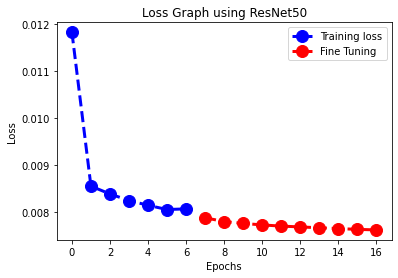

In [ ]:

loss = training.history['loss']
ftuning = fine_tuning.history['loss']
epochs = range(7)
epochs1 = range(7,17)
plt.plot(epochs, loss, color='blue', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=12, label='Training loss')
plt.plot(epochs1, ftuning, color='red', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='red', markersize=12, label='Fine Tuning')
plt.title('Loss Graph using ResNet50')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

###Saving the Model

In [ ]:
# save as H5 format (TF)
mdl.save('/content/drive/MyDrive/hinton.h5')

In [ ]:
# you need a few more libraries to work with ONNX
!pip install tf2onnx onnxruntime onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 442 kB 24.6 MB/s 
     |████████████████████████████████| 4.5 MB 65.2 MB/s 
     |████████████████████████████████| 13.1 MB 58.6 MB/s 
     |████████████████████████████████| 46 kB 3.8 MB/s 
     |████████████████████████████████| 86 kB 6.8 MB/s 


In [ ]:
import tf2onnx

model_proto, external_tensor_storage = tf2onnx.convert.from_keras(mdl)
with open('/content/drive/MyDrive/hinton.onnx', 'wb') as f:
    f.write(model_proto.SerializeToString())

###Exploring the Results

In [ ]:
for x, y in validation:
  break


In [ ]:
z = mdl.predict(x)

1/1 [==============================] - 1s 1s/step


In [ ]:
z = tf.squeeze(z)

In [ ]:
z.shape

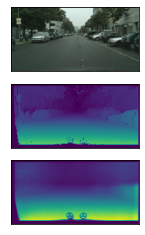

In [ ]:
#pred = mdl.predict(np.expand_dims(x[2], 0))
plt.subplot(3,1,1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(x[6],  cmap=plt.cm.binary)
plt.subplot(3,1,2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(y[6])
plt.subplot(3,1,3)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(z[6])



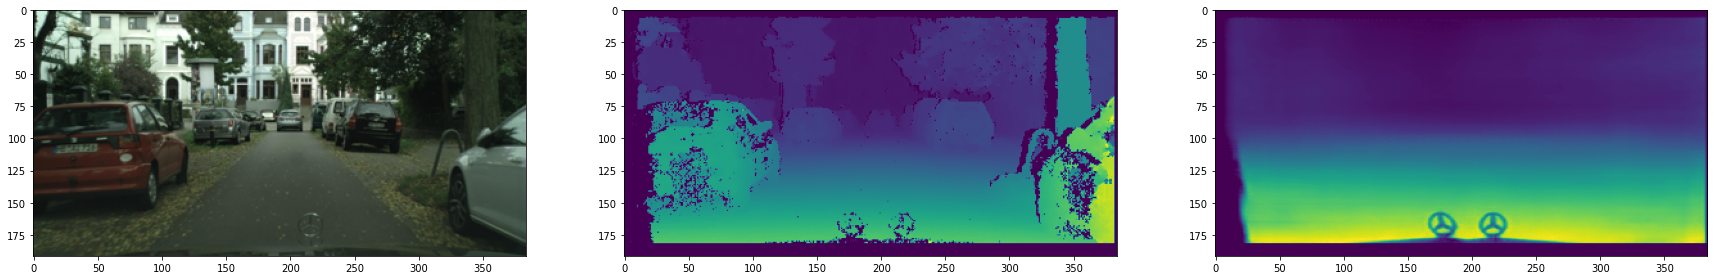

In [ ]:
fig,axis = plt.subplots(1,3,figsize=(30,15))
axis[0].imshow(x[0])
axis[1].imshow(y[0])
axis[2].imshow(z[0])
plt.show()

## Dummy benchmarks

In [ ]:
import time
import onnx
import onnxruntime as ort


# benchmark in tensorflow
loaded_mdl = tf.keras.models.load_model('/content/drive/MyDrive/hinton.h5')

# dummy dataset
test_data = test_X
#np.clip(128 + 50 *np.random.randn(16, 192, 384, 3), 0, 255).astype(np.uint8)
test_labels = test_y
#np.clip(128 + 50 *np.random.randn(16, 192, 384), 0, 255)/256

error = 0
start_time = time.time()
for cnt in range(len(test_data)):
    pred = loaded_mdl.predict(np.expand_dims(test_data[cnt], 0))
    error += np.sum((test_labels[cnt] - np.squeeze(pred))**2)
runtime = time.time() - start_time
print(f'Python MSE = {error/(cnt+1)}, runtime = {runtime/(cnt+1)}')

1/1 [==============================] - 0s 22ms/step
Python MSE = 146.90776255130768, runtime = 0.08840673714876175


In [ ]:
onnx.checker.check_model(onnx.load('/content/drive/MyDrive/hinton.onnx'))
ort_sess = ort.InferenceSession('/content/drive/MyDrive/hinton.onnx')

error = 0
start_time = time.time()
cnt = 0
while cnt*batch_size < len(test_data):
    onnx_out = ort_sess.run(None, {'input_3': test_data[cnt*batch_size:(cnt+1)*batch_size, :, :, :]})
    pred = np.squeeze(onnx_out).ravel()
    error += np.sum((test_labels[cnt*batch_size:(cnt+1)*batch_size].ravel() - pred)**2)
    cnt += 1
runtime = time.time() - start_time
print(f'ONNX MSE = {error/cnt/batch_size}, runtime = {runtime/cnt/batch_size}')

ONNX MSE = 146.9078108215332, runtime = 0.6451621055603027
